In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.9646779971569724


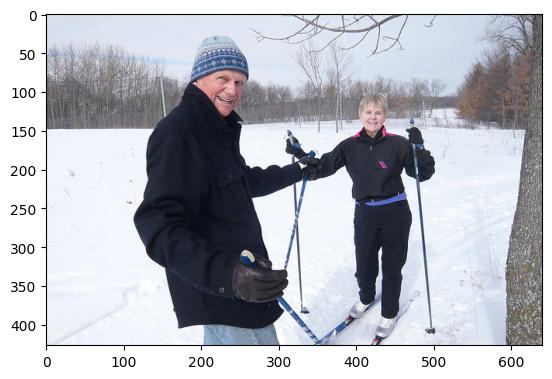

In [22]:
import IPython.display as ipd

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/music/' + music_id + '.wav'
    image_path = 'data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [26]:
train_image_ids = train_data['image_id'].unique()
val_image_ids = val_data['image_id'].unique()
test_image_ids = test_data['image_id'].unique()

train_image_ids = [image_id + '.jpg' for image_id in train_image_ids]
val_image_ids = [image_id + '.jpg' for image_id in val_image_ids]
test_image_ids = [image_id + '.jpg' for image_id in test_image_ids]

image_ids = train_image_ids + val_image_ids + test_image_ids
image_ids = np.unique(image_ids)
len(image_ids)

12609

In [25]:
# delete unused images
for image_id in tqdm(os.listdir('data/images')):
    if image_id not in image_ids:
        os.remove('data/images/' + image_id)

print(f'Total images: {len(os.listdir("data/images"))}')

100%|██████████| 12609/12609 [00:01<00:00, 8743.95it/s] 

Total images: 12609


In [112]:
import torch
from torch.utils.data import Dataset, DataLoader

IMAGE_PATH = 'data/images/'
MUSIC_PATH = 'data/music/'

class MusicImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self._load()

    def _load(self):
        self.data = []
        for _, row in tqdm(self.dataframe.iterrows()):
            music_id = row['music_id']
            image_id = row['image_id']
            music_path = MUSIC_PATH + music_id + '.wav'
            image_path = IMAGE_PATH + image_id + '.jpg'

            music = torch.load(music_path)
            image = plt.imread(image_path) 

            self.data.append((music, image))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]